### Imports

In [120]:
import cv2
import time

import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter, medfilt
from helpers.limbus_detection import detect_circle, detect_pupil_thresh
from helpers.misc import \
    jiggle_circle, tighten_circle, repair_bbox, is_circle_enclosed, geometric_median
from helpers.view_detection import get_view_mask

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


size: 476x255


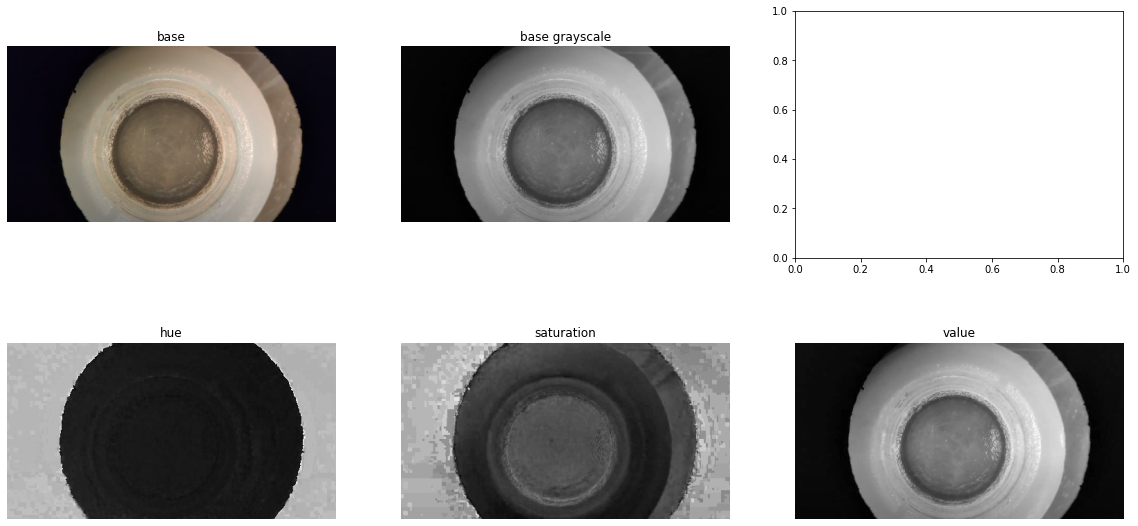

In [101]:
scale = 0.33
# scale = 1.0

base = cv2.imread('data/artificial/bioniko_rhexis_base8.png', cv2.IMREAD_COLOR)
base = cv2.resize(base, (0,0), fx=scale, fy=scale)

base_rgb = cv2.cvtColor(base, cv2.COLOR_BGR2RGB)
base_gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)

base_hue = base_hsv[:,:,0]
base_saturation = base_hsv[:,:,1]
base_value = base_hsv[:,:,2]

# visualization
print('size: %dx%d' % (base.shape[1], base.shape[0]))

fig, ((plot1, plot2, _), (plot3, plot4, plot5)) = plt.subplots(2, 3, figsize=(20,10))
plot1.set_title('base')
plot1.imshow(base_rgb)
plot1.axis('off')

plot2.set_title('base grayscale')
plot2.imshow(base_gray, cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('hue')
plot3.imshow(base_hue, cmap=plt.cm.gray)
plot3.axis('off')

plot4.set_title('saturation')
plot4.imshow(base_saturation, cmap=plt.cm.gray)
plot4.axis('off')

plot5.set_title('value')
plot5.imshow(base_value, cmap=plt.cm.gray)
plot5.axis('off')

plt.show()

### Color selection by mouse clicking

selected points: [(261, 112), (262, 171), (222, 207), (178, 163), (198, 121), (228, 163), (250, 155)]


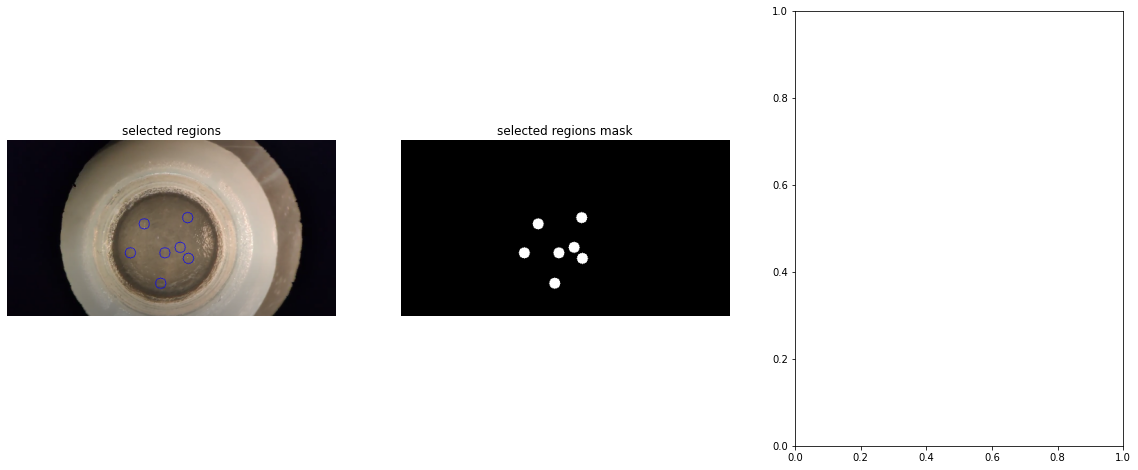

In [102]:
SELECTION_RADIUS = round(np.min(base_rgb.shape[:2])*0.03)

points = []
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONUP:
        points.append((x, y))
        
window_name = 'point selection'
cv2.namedWindow(window_name)
cv2.setMouseCallback(window_name, mouse_callback)
cv2.imshow(window_name, base)

ip = cv2.waitKey(0) & 0xFF
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)
        
print('selected points: %s' % str(points))
        
# visualization
base_rgb_copy = base_rgb.copy()
selection_mask = np.zeros(base_rgb.shape[:2], dtype=np.uint8)
for point in points:
    cv2.circle(base_rgb_copy, point, SELECTION_RADIUS, (0,0,255))
    cv2.circle(selection_mask, point, SELECTION_RADIUS, 255, cv2.FILLED)

fig, plots = plt.subplots(1, 3, figsize=(20,8))
plots[0].set_title('selected regions')
plots[0].imshow(base_rgb_copy)
plots[0].axis('off')

plots[1].set_title('selected regions mask')
plots[1].imshow(selection_mask, cmap='gray')
plots[1].axis('off')

plt.show()

histogram back projection

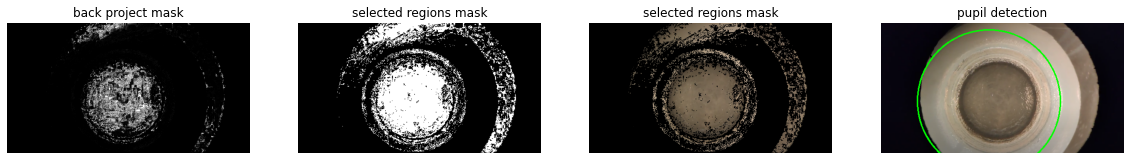

In [103]:
hist_hs = cv2.calcHist([base_hsv], [0,1], selection_mask, [180,256], [0,180,0,256])
back_project = cv2.calcBackProject([base_hsv], [0, 1], hist_hs, [0, 180, 0, 256], 1)

_, back_project_mask = cv2.threshold(back_project, 0, 255, cv2.THRESH_BINARY)
base_rgb_copy = base_rgb.copy()
base_rgb_copy[back_project_mask == 0] = [0,0,0]

base_rgb_copy2 = base_rgb.copy()
circle = detect_pupil_thresh(back_project_mask, pca_correction=True)
cv2.circle(base_rgb_copy2, tuple(circle[:2].round().astype(np.int64)), round(circle[2]), (0,255,0), 2)      

fig, plots = plt.subplots(1, 4, figsize=(20,8))
plots[0].set_title('back project mask')
plots[0].imshow(back_project, cmap='gray')
plots[0].axis('off')

plots[1].set_title('selected regions mask')
plots[1].imshow(back_project_mask, cmap='gray')
plots[1].axis('off')

plots[2].set_title('selected regions mask')
plots[2].imshow(base_rgb_copy)
plots[2].axis('off')

plots[3].set_title('pupil detection')
plots[3].imshow(base_rgb_copy2)
plots[3].axis('off')

plt.show()

### Circle template matching

In [104]:
def template_match_circle(mask, radius):
    circle_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (round(2*radius), round(2*radius)))
    
    if circle_kernel.shape[0] >= np.min(mask.shape):
        return None
    
    result = cv2.matchTemplate(mask, circle_kernel, cv2.TM_CCORR_NORMED)
    _, max_val, _, max_loc = cv2.minMaxLoc(result)
    
    max_loc = (max_loc[0] + circle_kernel.shape[0]//2, 
               max_loc[1] + circle_kernel.shape[1]//2)

    return max_val, max_loc, cv2.normalize(result, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8UC1)

In [105]:
def last_where(bool_array):
    return len(bool_array) - 1 - np.argmax(np.flip(bool_array))

radius initialization using pca

radius initialization: 148.872971


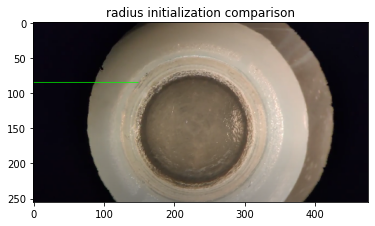

In [106]:
RADIUS_INIT_SCALE = 1.0 # to make up for bad calibration

points = np.array((np.where(back_project_mask == 255)[1], np.where(back_project_mask == 255)[0])).T
points = points.astype(np.float32)

mean = np.empty((0))
mean, eigenvectors, eigenvalues = cv2.PCACompute2(points, mean)
mean = mean[0]

radius_init = 2*np.sqrt(eigenvalues[0,0])
radius_init *= RADIUS_INIT_SCALE

base_rgb_copy = base_rgb.copy()
cv2.line(base_rgb_copy, (0,base_rgb.shape[0]//3), 
         (round(radius_init),base_rgb.shape[0]//3), (0,255,0))

# visualization
print('radius initialization: %f' % radius_init)

plt.imshow(base_rgb_copy)
plt.title('radius initialization comparison')

plt.show()

decreasing radius size iteratively

execution time: 0.232562 s, 4.299927 fps
best index: 50, radius: 76.872971


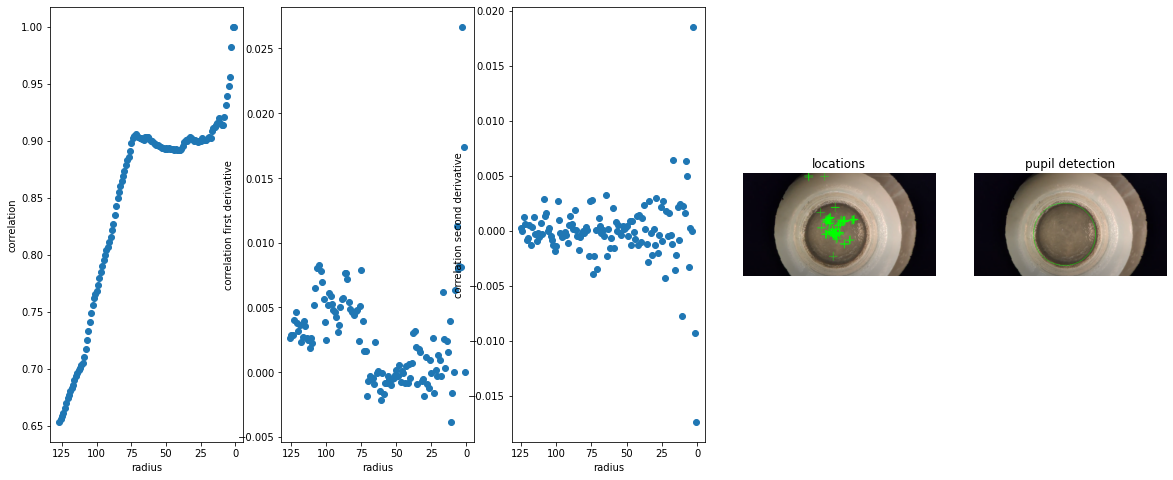

In [142]:
radii = []
max_vals = []
max_locs = []

radius = radius_init
start = time.time()
for _ in range(200):
    if radius <= 0:
        break
    
    result = template_match_circle(back_project_mask, radius)
    if result is not None:
        max_val, max_loc, _ = result
        radii.append(radius)
        max_vals.append(max_val)
        max_locs.append(max_loc)
    
    radius -= 1
end = time.time()

# numpy conversion
radii = np.array(radii)
max_vals = np.array(max_vals)
max_locs = np.array(max_locs)
    
base_rgb_copy = base_rgb.copy()
for loc in max_locs:
    cv2.drawMarker(base_rgb_copy, loc, (0,255,0))
    
base_rgb_copy2 = base_rgb.copy()
# best_index = 5
best_index = 50
cv2.circle(base_rgb_copy2, max_locs[best_index], round(radii[best_index]), (0,255,0))

max_loc_diffs = []
last_loc = max_locs[0]
for loc in max_locs[1:]:
    max_loc_diffs.append(np.linalg.norm(np.array(last_loc) - np.array(loc)))
    last_loc = loc

# visualization
print('execution time: %f s, %f fps' % ((end - start), 1/(end - start)))
print('best index: %d, radius: %f' % (best_index, radii[best_index]))

fig, plots = plt.subplots(1, 5, figsize=(20,8))
plots[0].scatter(radii, max_vals)
plots[0].set_xlabel('radius')
plots[0].set_ylabel('correlation')
plots[0].invert_xaxis()

plots[1].scatter(radii[1:], np.diff(max_vals, n=1))
plots[1].set_xlabel('radius')
plots[1].set_ylabel('correlation first derivative')
plots[1].invert_xaxis()

plots[2].scatter(radii[2:], np.diff(max_vals, n=2))
plots[2].set_xlabel('radius')
plots[2].set_ylabel('correlation second derivative')
plots[2].invert_xaxis()

plots[3].set_title('locations')
plots[3].imshow(base_rgb_copy)
plots[3].axis('off')

plots[4].set_title('pupil detection')
plots[4].imshow(base_rgb_copy2)
plots[4].axis('off')

plt.show()

linear fit to the radius/correlation curve

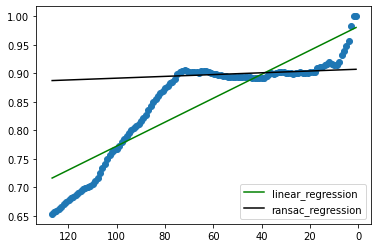

In [137]:
lr = linear_model.LinearRegression()
lr.fit(radii.reshape(-1, 1), max_vals)

ransac = linear_model.RANSACRegressor()
ransac.fit(radii.reshape(-1, 1), max_vals)

line_x = np.arange(radii.min(), radii.max(), 0.2).reshape(-1, 1)
line_y = lr.predict(line_x)
line_y_ransac = ransac.predict(line_x)

plt.scatter(radii, max_vals)
plt.plot(line_x, line_y, c='g',label='linear_regression')
plt.plot(line_x, line_y_ransac, c='k',label='ransac_regression')
plt.legend(loc='lower right')
plt.gca().invert_xaxis()
plt.show()

Savitzky-Golay filtering followed by differentiation

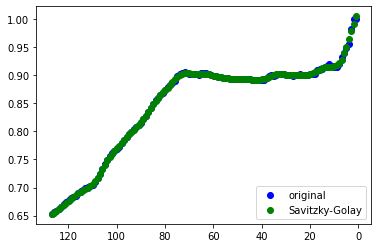

In [153]:
y_savgol = savgol_filter(max_vals, window_length=11, polyorder=3)

plt.scatter(radii, max_vals, c='b', label='original')
plt.scatter(radii, y_savgol, c='g', label='Savitzky-Golay')
plt.legend(loc='lower right')
plt.gca().invert_xaxis()
plt.show()

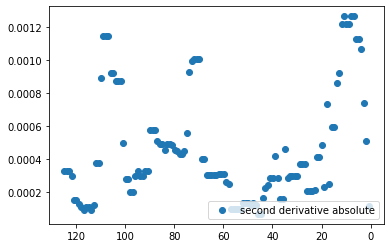

In [154]:
second_derivative = np.abs(np.diff(y_savgol, n=2))
second_derivative = medfilt(second_derivative, kernel_size=5)

plt.scatter(radii[2:], second_derivative,  label='second derivative absolute')
plt.legend(loc='lower right')
plt.gca().invert_xaxis()
plt.show()

In [152]:
def get_last_stationary_index(y):
    second_derivative = np.abs(np.diff(y, n=2))
    second_derivative = medfilt(second_derivative, kernel_size=5)
    best_index = 0
    for index in range(1, len(second_derivative)):
        if second_derivative[index] > second_derivative[best_index]:
            break
            
        best_index = index
        
    return best_index + 2

best_index: 31, radius: 95.872971, correlation: 0.790277


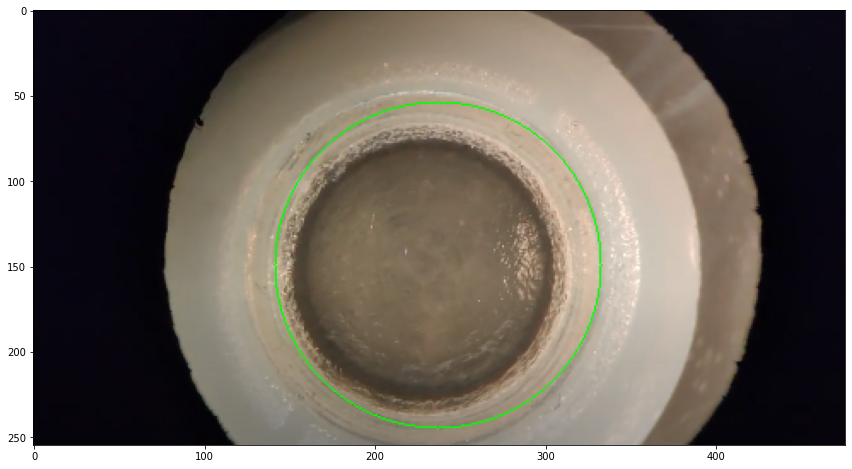

In [149]:
best_index = get_last_stationary_index(y_savgol)

print('best_index: %d, radius: %f, correlation: %f' % (best_index, radii[best_index], max_vals[best_index]))
base_rgb_copy = base_rgb.copy()
cv2.circle(base_rgb_copy, max_locs[best_index], round(radii[best_index]), (0,255,0))

_, plot = plt.subplots(1, 1, figsize=(15,8))
plot.imshow(base_rgb_copy)
plt.show()

In [13]:
radii[50]

76.512090817996

In [15]:
len(max_vals) - last_where(np.diff(max_vals, n=1) < 0)

4

In [19]:
np.flip(np.diff(max_vals, n=1))

array([ 0.01813656,  0.        , -0.01740646,  0.        ,  0.        ,
        0.01781458,  0.        , -0.01538873,  0.        ,  0.01658338,
        0.        , -0.01616561,  0.        ,  0.01517481,  0.        ,
       -0.01292235,  0.        ,  0.01479018,  0.        , -0.01755083,
        0.        ,  0.01434898,  0.        , -0.0125981 ,  0.        ,
        0.01379097,  0.        , -0.01285577,  0.01406413,  0.        ,
       -0.01387787,  0.        ,  0.0127809 ,  0.        , -0.01126307,
        0.01174819,  0.        , -0.01306689,  0.01205415,  0.        ,
       -0.01104075,  0.        ,  0.01125181, -0.01119673,  0.        ,
        0.00963944, -0.00919622,  0.        ,  0.00994891, -0.00977659,
        0.00968432,  0.        , -0.01062351,  0.00966853,  0.        ,
       -0.00989342,  0.00927192, -0.00794935,  0.        ,  0.00995952,
       -0.00914556,  0.01046407, -0.01062232,  0.        ,  0.01054704,
       -0.01139456,  0.00968176, -0.00952923,  0.00983143,  0.  

In [254]:
image = back_project_mask.copy()

rows, cols = image.shape
m = cv2.getOptimalDFTSize( rows )
n = cv2.getOptimalDFTSize( cols )
padded = cv2.copyMakeBorder(image, 0, m - rows, 0, n - cols, cv2.BORDER_CONSTANT, value=[0, 0, 0])

planes = [np.float32(padded), np.zeros(padded.shape, np.float32)]
complex_back_project = cv2.merge(planes)         # Add to the expanded another plane with zeros

cv2.dft(complex_back_project, complex_back_project)         # this way the result may fit in the source matrix

cv2.split(complex_back_project, planes)                   # planes[0] = Re(DFT(back_project), planes[1] = back_projectm(DFT(back_project))
cv2.magnitude(planes[0], planes[1], planes[0])# planes[0] = magnitude
mag_back_project = planes[0]

mat_of_ones = np.ones(mag_back_project.shape, dtype=mag_back_project.dtype)
cv2.add(mat_of_ones, mag_back_project, mag_back_project) #  switch to logarithmic scale
cv2.log(mag_back_project, mag_back_project)

mag_back_project_rows, mag_back_project_cols = mag_back_project.shape
# crop the spectrum, if it has an odd number of rows or columns
mag_back_project = mag_back_project[0:(mag_back_project_rows & -2), 0:(mag_back_project_cols & -2)]
cx = int(mag_back_project_rows/2)
cy = int(mag_back_project_cols/2)
q0 = mag_back_project[0:cx, 0:cy]         # Top-Left - Create a ROback_project per quadrant
q1 = mag_back_project[cx:cx+cx, 0:cy]     # Top-Right
q2 = mag_back_project[0:cx, cy:cy+cy]     # Bottom-Left
q3 = mag_back_project[cx:cx+cx, cy:cy+cy] # Bottom-Right
tmp = np.copy(q0)               # swap quadrants (Top-Left with Bottom-Right)
mag_back_project[0:cx, 0:cy] = q3
mag_back_project[cx:cx + cx, cy:cy + cy] = tmp
tmp = np.copy(q1)               # swap quadrant (Top-Right with Bottom-Left)
mag_back_project[cx:cx + cx, 0:cy] = q2
mag_back_project[0:cx, cy:cy + cy] = tmp

mag_back_project = cv2.normalize(mag_back_project, mag_back_project, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1) # Transform the matrix with float values into a

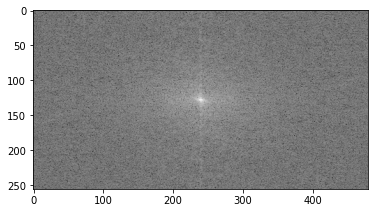

In [255]:
# mag_back_project[128,240] = 0
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(mag_back_project)

plt.imshow(mag_back_project, cmap='gray')

In [256]:
max_loc

(240, 128)

In [243]:
mag_back_project[240,128]

0

In [246]:
min_val

0.0